Construct a variation encoder trained on MNIST dataset to synthetically generate MNIST
looking handwritten digit images.

In [ ]:
# import required librarie and modules
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras

In [ ]:
# A random seed is used to ensure that results are reproducible
tf.random.set_seed(42)

In [ ]:
# self is always pointing to current Object
class Sampling(keras.layers.Layer):
  def call(self, inputs):
    mean, log_var = inputs
    return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [ ]:
# function to plot image
def plot_image(image):
  plt.imshow(image, cmap="Greys", interpolation="nearest")
  plt.axis("off")

In [ ]:
# function to display reconstructed images
def show_reconstructions(model, n_test_images = 2):
  reconstructions = model.predict(X_test[:n_test_images])
  fig = plt.figure(figsize=(8, 3 * n_test_images))
  for image_index in range(n_test_images):
    plt.subplot(n_test_images, 2, image_index * 2 + 1)
    plot_image(X_test[image_index])
    plt.subplot(n_test_images, 2, image_index * 2 + 2)
    plot_image(reconstructions[image_index])

In [ ]:
# function to display accuracy
def rounded_accuracy(y_true, y_pred):
  return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [ ]:
# load and normalize data
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = X_train / 255.0
X_test = X_test / 255.0

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# to access some useful functions like 'square', 'exp' etc. from Keras backend. 
K = keras.backend
# size of the latent space
codings_size = 10

In [ ]:
# build the encoder - functional API is used here - sequential can also be used. Scaled Exponential Linear Unit (SELU) activation function is used
inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [ ]:
# build the decoder
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

In [ ]:
# pass on the inputs to variational encoder and extract the feature distribution in the latent space (code)
_, _, codings = variational_encoder(inputs)

In [ ]:
# pass on codings to the variational decoder and extract the reconstructions
reconstructions = variational_decoder(codings)

In [ ]:
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

In [ ]:
# KL divergance
latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),axis=-1)

In [ ]:
variational_ae.add_loss(K.mean(latent_loss) / 784.)

In [ ]:
variational_ae.compile(loss="binary_crossentropy", optimizer="adam",
metrics=[rounded_accuracy])

In [ ]:
history = variational_ae.fit(X_train, X_train, epochs=10, batch_size=32)

Epoch 1/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.1851 - rounded_accuracy: 0.9275
Epoch 2/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1566 - rounded_accuracy: 0.9447
Epoch 3/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1516 - rounded_accuracy: 0.9479
Epoch 4/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.1487 - rounded_accuracy: 0.9497
Epoch 5/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1468 - rounded_accuracy: 0.9510
Epoch 6/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1452 - rounded_accuracy: 0.9520
Epoch 7/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1440 - rounded_accuracy: 0.9528
Epoch 8/10
1875/1875 [==============================] - 22s 12ms/step - loss: 0.1431 - rounded_accuracy: 0.9534
Epoch 9/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.1423 - rounded_accuracy: 0.954

In [ ]:
# function to plo images
def plot_multiple_images(images, n_cols=None):
  n_cols = n_cols or len(images)
  n_rows = (len(images) - 1) // n_cols + 1
  if images.shape[-1] == 1:
    images = np.squeeze(images, axis=-1)
  plt.figure(figsize=(n_cols, n_rows))
  for index, image in enumerate(images):
    plt.subplot(n_rows, n_cols, index + 1)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

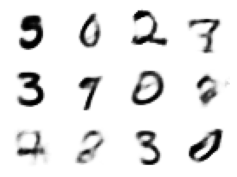

In [ ]:
# use random uniform distributions to generate images
codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)